In [1]:
# Common
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception

In [2]:
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1' # This will allow automatic expression to take place.

In [9]:
import os

# Specify root path
root_path = r"C:\Micro_Organism"

# Get class names
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Calculate class distribution
class_dis = [
    len(os.listdir(os.path.join(root_path, name)))
    for name in class_names
]

# Show
print(f"Number of Classes: {n_classes}")
print(f"Class names: {class_names}")
print(f"Class distribution: {class_dis}")


Number of Classes: 8
Class names: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']
Class distribution: [72, 168, 76, 152, 85, 86, 75, 75]


In [11]:
# Bar Plot
fig = px.bar(x=class_names, y=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [12]:
# Initialize generator
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3,0.8],
    validation_split=0.1
)

In [13]:
# Load Data
train_ds = gen.flow_from_directory(
    root_path,
    batch_size=128, # For better utilization of GPU, I have kept the batch size a little bit
    shuffle=True,
    class_mode='binary',
    target_size=(256,256), # This image size is generally sufficient for better image classifications.
    subset='training'
)

valid_ds = gen.flow_from_directory(
    root_path,
    batch_size=64, # For faster inference, the batch size here is small.
    shuffle=True,
    class_mode='binary',
    target_size=(256,256), # This image size is generally sufficient for better image classifications.
    subset='validation'
)

Found 714 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


In [14]:
def show_images(data, GRID=[2,6], model=None, size=(25,10)):
    
    # The plotting configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=size)
    
    # Data for visualization
    images, labels = next(iter(data)) # This process can take a little time because of the large batch size
    
    # Iterate through the subplots.
    for i in range(1, n_images+1):
        
        # Select a random data
        id = np.random.randint(len(images)) # This is a dynamic function because for validation data and training data, the length of total images is different.
        image, label = images[id], class_names[int(labels[id])]
        
        # Plot the sub plot
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.axis('off')
        
        # If model is available make predictions.
        if model is not None:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class : {label}\nPred : {pred}"
        else:
            title = f"Class : {label}"
        
        plt.title(title)
    plt.show()

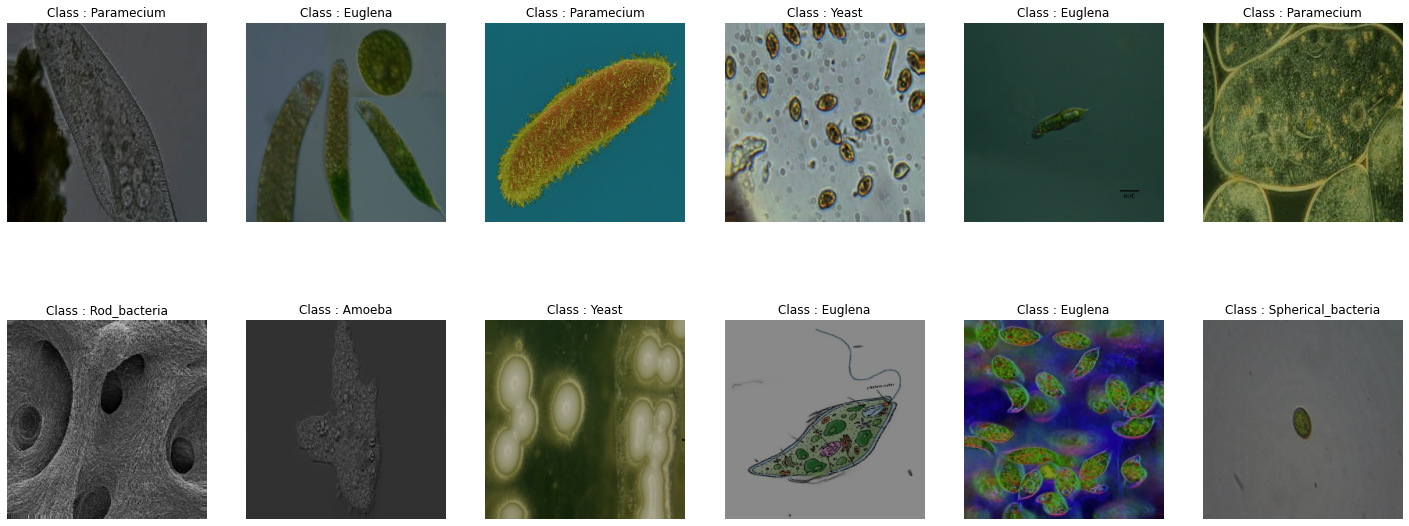

In [15]:
show_images(data=train_ds)

In [26]:
#call back is changed to 50 epochs so it doesnr stop

In [22]:
# Give you a model, a name
name = "inception-v3"

# Base model
base = InceptionV3(input_shape=(256,256,3), include_top=False)
base.trainable = False

# Model Architecture
model = Sequential([
    base, GAP(),
    Dense(256, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
])

# Compile Model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) # Higher than the default learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

cbs = [MC(name + ".h5", save_best_only=True)]

# Training
history = model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=cbs)

Epoch 1/50
6/6 [==============================] - 53s 8s/step - loss: 2.1226 - accuracy: 0.2409 - val_loss: 1.7536 - val_accuracy: 0.3600
Epoch 2/50
6/6 [==============================] - 45s 7s/step - loss: 1.4531 - accuracy: 0.5112 - val_loss: 1.3308 - val_accuracy: 0.5733
Epoch 3/50
6/6 [==============================] - 45s 7s/step - loss: 1.1732 - accuracy: 0.6106 - val_loss: 1.1489 - val_accuracy: 0.6000
Epoch 4/50
6/6 [==============================] - 43s 7s/step - loss: 0.9334 - accuracy: 0.6737 - val_loss: 1.1509 - val_accuracy: 0.5867
Epoch 5/50
6/6 [==============================] - 44s 7s/step - loss: 0.8255 - accuracy: 0.7325 - val_loss: 1.0144 - val_accuracy: 0.7200
Epoch 6/50
6/6 [==============================] - 45s 7s/step - loss: 0.7438 - accuracy: 0.7773 - val_loss: 1.0361 - val_accuracy: 0.6000
Epoch 7/50
6/6 [==============================] - 44s 7s/step - loss: 0.6652 - accuracy: 0.7787 - val_loss: 1.0172 - val_accuracy: 0.6133
Epoch 8/50
6/6 [==================

In [23]:

# Find and print the maximum validation accuracy
max_val_accuracy = max(history.history['val_accuracy'])
print(f"Maximum Validation Accuracy: {max_val_accuracy}")


Maximum Validation Accuracy: 0.7733333110809326


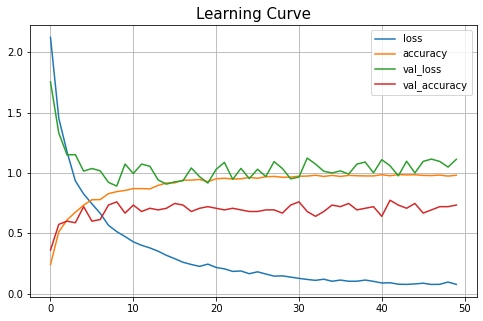

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.show()

# **Model predictions**

1/1 [==============================] - 0s 113ms/step


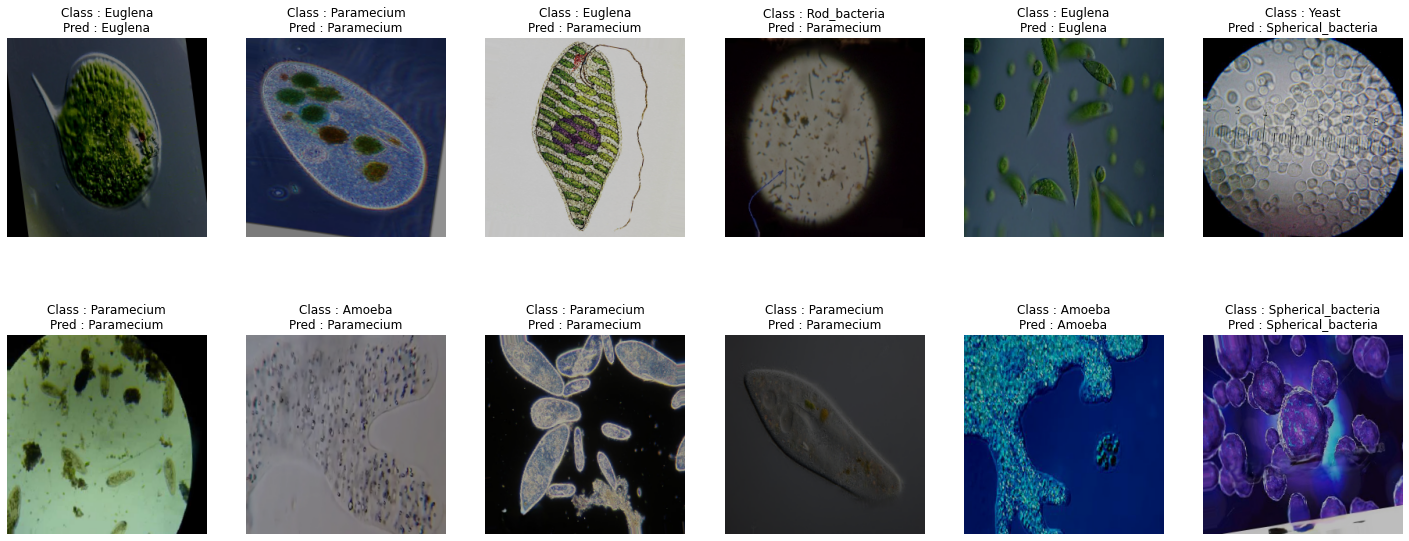

In [29]:
show_images(data=valid_ds, model=model)